### Speech representation and data exploration

In [50]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd
#Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa
from sklearn.decomposition import PCA
#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd
%matplotlib inline

## 1.Visualization

In [ ]:
#There are two theories of a human hearing - place ( https://en.wikipedia.org/wiki/Place_theory_(hearing) (frequency-based)
#and temporal (https://en.wikipedia.org/wiki/Temporal_theory_(hearing) ) In speech recognition, I see two main tendencies - to input spectrogram (frequencies), 
#and more sophisticated features MFCC - Mel-Frequency Cepstral Coefficients, PLP. You rarely work with raw, temporal data.


### 1.1 Wave and spectrogram 波和频谱图

In [51]:
#Choose and some file:
train_audio_path = "speech-recognition/test/audio/"
filename = "clip_00a2c3e3d.wav"
sample_rate, samples = wavfile.read(str(train_audio_path) + filename)

#### Define a function that calculates spectrogram
#### 请注意，我们采用的是频谱图值的对数。 此外，这将使我们的情节更加清晰，并且与人们的听觉方式紧密相关。 我们需要确保没有0值作为对数输入。


In [62]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

#### Frequencies are in range(0, 8000) according to Nyquist theorem. Let's plot it:

Text(0.5, 0, 'Seconds')

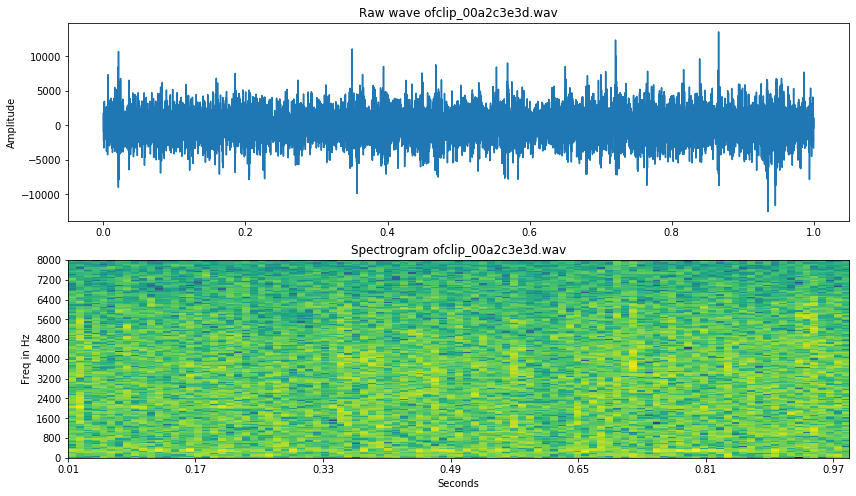

In [48]:
freqs, times, spectrogram = log_specgram(samples, sample_rate)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower',
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of' + filename)
ax2.set_ylabel('Freq in Hz')
ax2.set_xlabel('Seconds')

In [45]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

In [ ]:
#如果将频谱图用作NN的输入特征，则必须记住对特征进行归一化。 （我们需要对所有数据集进行归一化，这里仅是一个示例，它的平均值和标准差都不好！）
#有一个有趣的事实要指出。 每帧有〜160个特征，频率在0到8000之间。这意味着一个特征对应于50 Hz。 但是，耳朵的频率分辨率在1000 – 2000 Hz的八度范围内为3.6 Hz。这意味着，与上述频谱图所表示的相比，人们更加精确，并且可以听到小得多的细节。

### 1.2MFCC

In [ ]:
#Details of MFCC:http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/
# that it is well prepared to imitate human hearing properties.做好了模仿人类听力特性的准备。
#You can calculate Mel power spectrogram and MFCC using for example librosa python package.

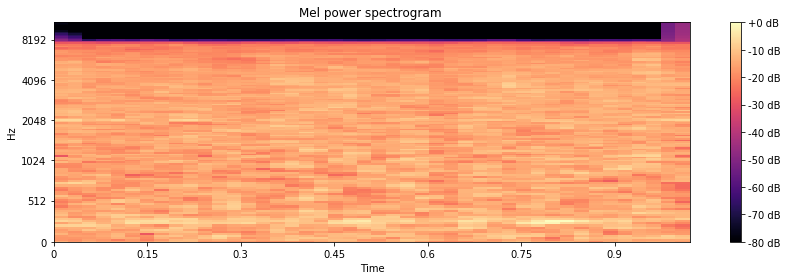

In [57]:
#https://github.com/librosa/librosa/blob/master/examples/LibROSA%20demo.ipynb
#samples, sample_rate = librosa.load(str(train_audio_path)+filename)
S = librosa.feature.melspectrogram(samples, sr=sample_rate, n_mels=128)
# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)
#在频谱图旁边显示click波形
plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

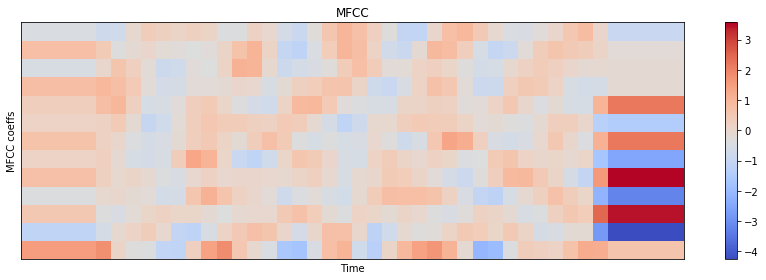

In [58]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)
#Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)
plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In [ ]:
#在经典但仍是最先进的系统中，MFCC或类似功能被用作系统的输入，而不是频谱图。
#但是，在端到端（通常基于神经网络）系统中，最常见的输入功能可能是原始频谱图或梅尔功率频谱图。 例如，MFCC对特征进行去相关，但是NN很好地处理了相关特征。 此外，如果您了解梅尔过滤器，则可以考虑使用它们是明智的。
#选择哪个是你的决定！

### 1.3 Spectrogram in 3d

In [64]:
data = [go.Surface(x=times, y=freqs, z=spectrogram.T)]
layout = go.Layout(
title='Specgtrogram of "yes" in 3d',
scene = dict(
yaxis = dict(title='Frequncy', range=[freqs.min(),freqs.max()]),
xaxis = dict(title='Time', range=[times.min(),times.max()],),
zaxis = dict(title='Log amplitude'),
),
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)
#Don't know how to set axis ranges to proper values yet. I'd also like it to be streched like a classic spectrogram above.

### 1.4 Silence removal

In [67]:
train_audio_path = "speech-recognition/test/audio/"
filename = "clip_00a6a875c.wav"
sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
ipd.Audio(samples, rate=sample_rate)

In [68]:
#我认为某些VAD（语音活动检测）在这里非常有用。 尽管这些词很短，但其中有很多沉默。 体面的VAD可以大大减少训练量，显着加快训练速度。 
#剪掉一部分文件。 再听一遍（根据上面的图，我们从4000到13000）
samples_cut = samples[4000:13000]
ipd.Audio(samples_cut, rate=sample_rate)

In [ ]:
#然而不可能手动剪切所有文件并基于简单图进行此操作。 但是可以使用例如webrtcvad软件包来获得良好的VAD。
#让我们再次绘制它，并猜测'w''e''l'字素的对齐方式

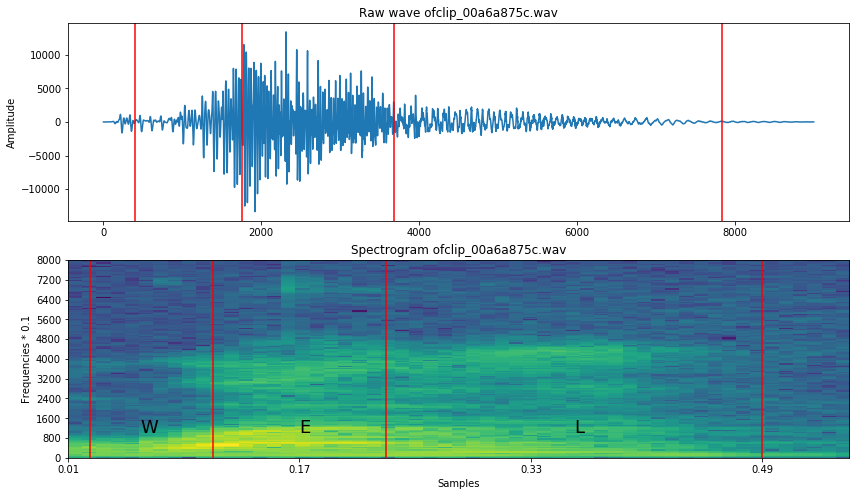

In [71]:
freqs, times, spectrogram_cut = log_specgram(samples_cut, sample_rate)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(samples_cut)

ax2 = fig.add_subplot(212)
ax2.set_title('Spectrogram of' + filename)
ax2.set_ylabel('Frequencies * 0.1')
ax2.set_xlabel('Samples')
ax2.imshow(spectrogram_cut.T, aspect='auto', origin='lower',
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.text(0.06, 1000, 'W', fontsize=18)
ax2.text(0.17, 1000, 'E', fontsize=18)
ax2.text(0.36, 1000, 'L', fontsize=18)

xcoords = [0.025, 0.11, 0.23, 0.49]
for xc in xcoords:
    ax1.axvline(x=xc*16000, c='r')
    ax2.axvline(x=xc, c='r')


### Resampling-dimensionality reduction

In [ ]:
#减少数据维数的另一种方法是对记录重新采样。
#We'll need to calculate FFT (Fast Fourier Transform). Definition: 计算FFT（快速傅立叶变换）

In [72]:
def custom_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    vals = 2.0/N * np.abs(yf[0:N//2]) #FFT is simmetrical, so we take just the first half
## FFT is also complex, to we take just the real part (abs)
    return xf, vals

In [ ]:
#让我们阅读一些录音，对其重新采样后聆听。 还可以比较FFT，但原始信号中几乎没有超过4000 Hz的信息。

In [74]:
filename = "clip_00a7b4c16.wav"
new_sample_rate = 8000
sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
resampled = signal.resample(samples, int(new_sample_rate/sample_rate * samples.shape[0]))

In [75]:
ipd.Audio(samples, rate = sample_rate)

In [76]:
ipd.Audio(resampled, rate=new_sample_rate)
#Have a little difference

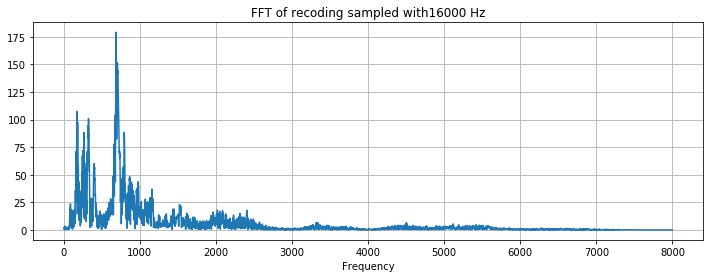

In [77]:
xf, vals = custom_fft(samples, sample_rate)
plt.figure(figsize=(12, 4))
plt.title('FFT of recoding sampled with' + str(sample_rate) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

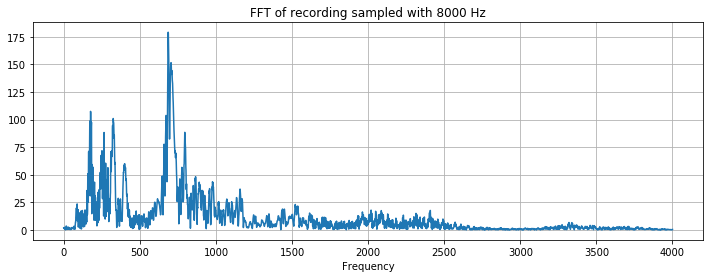

In [78]:
xf, vals = custom_fft(resampled, new_sample_rate)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(new_sample_rate) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()
#This is how we reduced dataset size twice!

In [ ]:
#1.6. Features extraction steps
#I would propose the feature extraction algorithm like that:
#Resampling
#VAD
#Maybe padding with 0 to make signals be equal length
#Log spectrogram (or MFCC, or PLP)
#Features normalization with mean and std
#Stacking of a given number of frames to get temporal information
#It's a pity it can't be done in notebook. It has not much sense to write things from zero, and everything is ready to take, but in packages, that can not be imported in Kernels.

## Dataset investigation

### 2.1 Number of records

In [79]:
dirs = [f for f in os.listdir(train_audio_path) if isdir(join(train_audio_path, f))]
dirs.sort()
print('Number of labels: ' + str(len(dirs)))

Number of labels: 0


In [80]:
# Calculate
number_of_recordings = []
for direct in dirs:
    waves = [f for f in os.listdir(join(train_audio_path, direct))
if f.endswith('.wav')]
    number_of_recordings.append(len(waves))

In [92]:
# Plot
data = [go.Histogram(x=dirs, y=number_of_recordings)]
trace = go.Bar(
    x=dirs,
    y=number_of_recordings,
    marker=dict(color = number_of_recordings, colorscale='Viridius', showscale=True
    ),
)
layout = go.Layout(
    title='Number of recordings in given label',
    xaxis = dict(title='Words'),
    yaxis = dict(title='Number of recordings')
)
py.iplot(go.Figure(data=[trace], layout=layout))

ValueError: 
    Invalid value of type 'builtins.str' received for the 'colorscale' property of bar.marker
        Received value: 'Viridius'

    The 'colorscale' property is a colorscale and may be
    specified as:
      - A list of colors that will be spaced evenly to create the colorscale.
        Many predefined colorscale lists are included in the sequential, diverging,
        and cyclical modules in the plotly.colors package.
      - A list of 2-element lists where the first element is the
        normalized color level value (starting at 0 and ending at 1), 
        and the second item is a valid color string.
        (e.g. [[0, 'green'], [0.5, 'red'], [1.0, 'rgb(0, 0, 255)']])
      - One of the following named colorscales:
            ['aggrnyl', 'agsunset', 'algae', 'amp', 'armyrose', 'balance',
             'blackbody', 'bluered', 'blues', 'blugrn', 'bluyl', 'brbg',
             'brwnyl', 'bugn', 'bupu', 'burg', 'burgyl', 'cividis', 'curl',
             'darkmint', 'deep', 'delta', 'dense', 'earth', 'edge', 'electric',
             'emrld', 'fall', 'geyser', 'gnbu', 'gray', 'greens', 'greys',
             'haline', 'hot', 'hsv', 'ice', 'icefire', 'inferno', 'jet',
             'magenta', 'magma', 'matter', 'mint', 'mrybm', 'mygbm', 'oranges',
             'orrd', 'oryel', 'peach', 'phase', 'picnic', 'pinkyl', 'piyg',
             'plasma', 'plotly3', 'portland', 'prgn', 'pubu', 'pubugn', 'puor',
             'purd', 'purp', 'purples', 'purpor', 'rainbow', 'rdbu', 'rdgy',
             'rdpu', 'rdylbu', 'rdylgn', 'redor', 'reds', 'solar', 'spectral',
             'speed', 'sunset', 'sunsetdark', 'teal', 'tealgrn', 'tealrose',
             'tempo', 'temps', 'thermal', 'tropic', 'turbid', 'twilight',
             'viridis', 'ylgn', 'ylgnbu', 'ylorbr', 'ylorrd'].
        Appending '_r' to a named colorscale reverses it.


### Deeper into recordings

In [ ]:
#有一个非常重要的事实。 录音来自非常不同的来源。 据我所知，其中一些可能来自移动GSM频道。
#尽管如此，以不会在训练和测试集中都出现一位发言人的方式来分割数据集是非常重要的。 看看下面这两个例子：

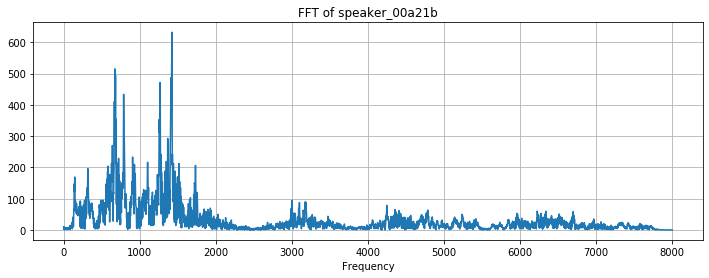

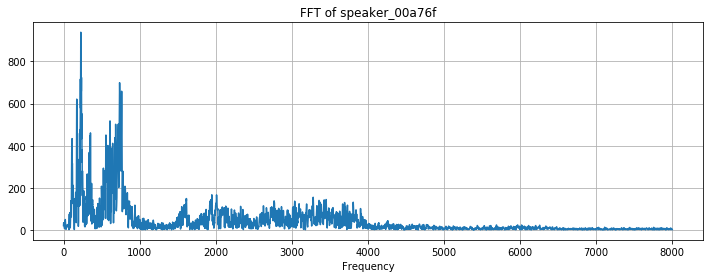

In [94]:
filenames = ['clip_00a21b08b.wav', 'clip_00a76ffdd.wav']
for filename in filenames:
    sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
    xf, vals = custom_fft(samples, sample_rate)
    plt.figure(figsize=(12, 4))
    plt.title('FFT of speaker' + filename[4: 11])
    plt.plot(xf, vals)
    plt.xlabel('Frequency')
    plt.grid()
    plt.show()

In [95]:
#Even better to listen:
print('Speaker' + filenames[0][4:11])
ipd.Audio(join(train_audio_path, filenames[0]))

Speaker_00a21b


In [98]:
print('Speaker' + filename[1][4:11])
ipd.Audio(join(train_audio_path, filenames[1]))

Speaker


### 2.3 Recordings length

In [99]:
#Find if all the files have 1 second duration:
number_of_shorter = 0
for direct in dirs:
    waves = [f for f in os.listdir(join(train_audio_path, direct))
if f.endwith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + direct + '/' + wav)
        if samples.shape[0] < sample_rate:
            number_of_shorter += 1
print('Number of recordings shorter than 1 second: ' + str(number_of_shorter))

Number of recordings shorter than 1 second: 0


### 2.4 Mean spectrograms and FFT

In [101]:
#Let's plot mean FFT for every word
to_keep = 'yes no up down left right on off stop go'.split()
dirs = [d for d in dirs if d in to_keep]
print(dirs)

for direct in dirs:
    vals_all = []
    spec_all = []
    waves = [f for f in os.listdir(join(train_audio_path, direct))
if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + direct + '/' + wav)
        if samples.shape[0] !=16000:
            continue
        xf, vals = custom_fft(samples, 16000)
        vals_all.append(vals)
        freqs, times, spec = log_specgram(samples, 16000)
        spec_all.append(spec)
        
    plt.figure(figsize=(14, 4))
    plt.subplot(121)
    plt.title('Mean fft of ' + direct)
    plt.plot(np.mean(no.array(vals_all), axis=0))
    plt.grid()
    plt.subplot(122)
    plt.title('Mean specgram of ' + direct)
    plt.imshow(np.mean(np.array(spec_all), axis=0).T, aspect='auto', origin='lower',
               extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    plt.yticks(freqs[::16])
    plt.xticks(times[::16])
    plt.show()

[]
